# Exploratory Data Analysis (EDA):
**Disclaimer!** the EDA was done in the first stages of the thesis so a lot of the figures here didn't end up being used in the final version

In this notebook you'll find part of the EDA of the thesis **Temporal Clustering of Citizen-Contributed Data for Air Pollution Pattern Recognition**. Even thought this notebook doesn't contain all the analysis that has to be done with the given data, it's a starting point for understanding the dataset and make it suitable for the methodology that will be applied.

### Objective of the EDA

The main objective of this EDA is to obtain enough information to be able to transform the original longitudinal data into a multivariate time series that includes as much information as possible so that it can be used as input for different models.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from scipy.stats import lognorm, trim_mean
import math
import numpy as np

In [2]:
#We read raw smell reports' longitudinal data
data = pd.read_csv("../Data/dataset/v2.1/smell_raw.csv")

#We get the date in a human-readable format (Pittsburgh's time zone is New York's)
tz = pytz.timezone('America/New_York')
data["date"] = data["EpochTime"].apply(lambda epoch : datetime.fromtimestamp(epoch, tz).strftime('%Y-%m-%d'))
data.columns
data

,EpochTime,skewed_latitude,skewed_longitude,smell_value,smell_description,feelings_symptoms,additional_comments,zipcode,date
0,1477935134,40.4293,-79.8720,1,NaN,NaN,NaN,15221,2016-10-31
1,1477935767,40.3624,-79.9749,1,NaN,NaN,NaN,15227,2016-10-31
2,1477955141,40.3275,-79.9606,1,NaN,NaN,NaN,15236,2016-10-31
3,1477956180,40.4252,-79.8956,2,Woodsmoke,NaN,NaN,15218,2016-10-31
4,1477956293,40.4237,-79.8964,3,Wood smoke,NaN,NaN,15218,2016-10-31
...,...,...,...,...,...,...,...,...,...
79848,1670716491,40.4353,-79.8807,4,Industrial,Eye irritation,NaN,15221,2022-12-10
79849,1670721226,40.4507,-79.9434,5,NaN,NaN,NaN,15213,2022-12-10
79850,1670725432,40.4307,-79.9826,4,Sulfur,NaN,NaN,15203,2022-12-10
79851,1670727013,40.4255,-79.8262,4,Industrial,NaN,NaN,15235,2022-12-10


### Overview of raw longitudinal data:

In [3]:
print(f"The dataset has {data.shape[0]} reports.")
total_reports = data.shape[0]
avg =  data.shape[0] / (datetime.strptime(data['date'].max(), "%Y-%m-%d") - datetime.strptime(data['date'].min(), "%Y-%m-%d")).days
print(f"Those reports go from {data['date'].min()} to {data['date'].max()}. An average of {round(avg, 1)} reports per day")
print(f"The most common intensity report is {data['smell_value'].value_counts().idxmax()}")
print(f"The average intensity report is {round(data['smell_value'].mean(), 2)}")

print("\nAdditional data: (percentage of reports that include it)")
print(f"Smell Description: {100 - round(data['smell_description'].isna().sum()/total_reports * 100, 2)}%")
print(f"Feeling Symptoms: {100 - round(data['feelings_symptoms'].isna().sum()/total_reports * 100, 2)}%")
print(f"Additional data: {100 - round(data['additional_comments'].isna().sum()/total_reports * 100, 1)}%")

The dataset has 79853 reports.
Those reports go from 2016-10-31 to 2022-12-10. An average of 35.8 reports per day
The most common intensity report is 4
The average intensity report is 3.66

Additional data: (percentage of reports that include it)
Smell Description: 70.12%
Feeling Symptoms: 35.05%
Additional data: 17.5%


### Visualization of the data as a daily time-series

2231


<Figure size 640x1000 with 0 Axes>

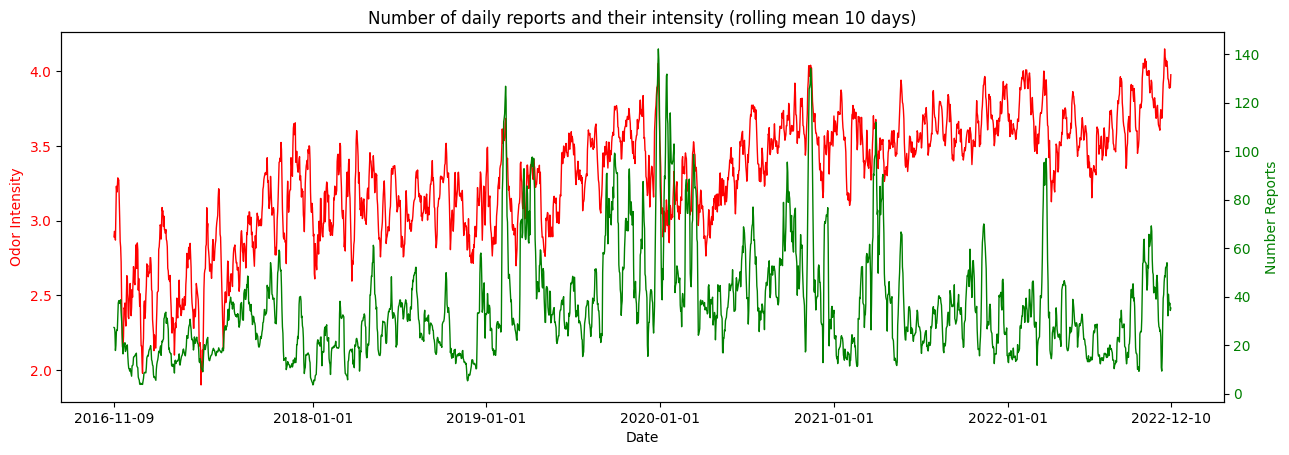

In [4]:
# The longitudinal data is tranformed to a time-series
ts_data = data.groupby("date").agg({"smell_value": ['mean', 'count', 'median']})
ts_data.columns = ts_data.columns.droplevel(0)

print(ts_data.shape[0])

rolling_mean = 10
# Mean smell intensity in rolling 10 dats and total number of reports
smell_intensity = ts_data['mean'].rolling(rolling_mean).mean()
num_entries = ts_data['count'].rolling(rolling_mean).mean()
date = list(smell_intensity.keys())

plt.figure().set_figheight(10)
plt.figure().set_figwidth(15)

# Creating first Axe of the plot
ax1 = plt.subplot()
ax1.set_xlabel("Date")
l1, = ax1.plot(date, smell_intensity, color='red', lw=1, label="smell intensity")
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_ylabel("Odor Intensity", color='red')
# Creating second Axe of plot
ax2 = ax1.twinx()
l2, = ax2.plot(date, num_entries, color='green', lw=1, label="reports per day")
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylabel("Number Reports", color='green')

ax2.set_xticks([date[rolling_mean-1], '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01', date[-1]])
plt.title("Number of daily reports and their intensity (rolling mean 10 days)")
plt.show()


### Feature Engineering experiments

In this sections we will perform different experiments so we can get the necessary assumptions to create the multivariate time series.

#### How should the aggregation be done. Daily. Twice a day. Three times a day,...

<AxesSubplot: xlabel='hour', ylabel='Count'>

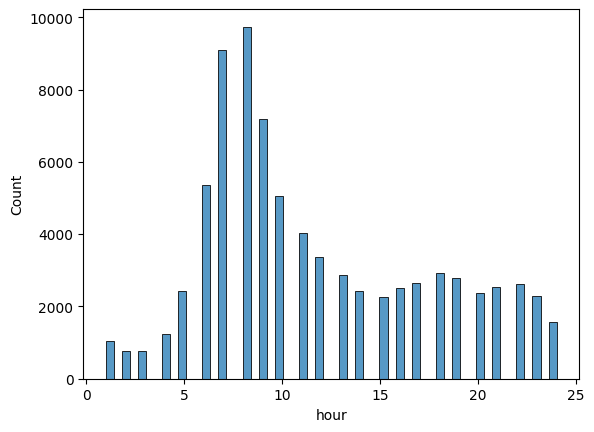

In [5]:
def hour(epoch):
    hour = datetime.utcfromtimestamp(3600 * ((epoch + 1800) // 3600)).hour - 5
    return hour if hour > 0 else hour + 24

data_hourly = data.copy()
data_hourly["hour"] = data_hourly['EpochTime'].apply((lambda epoch: hour(epoch)))

sns.histplot(data_hourly["hour"])

As there is only one peak at the beginning of the day (from 06:00 to 10:00) getting the aggregate per day (24 hours) is the right choice so we won't miss any moment of the day.

However, if we divide the data in days we'll only have around 2000 datapoints and that might not be enough for a Neural Network. Therefore more datapoints will be created by aggregating 24-hours-data with a window of 5 hours. Therefore we will have the same distribution as the daily timeseries but the transition between days will be smoother.

In [6]:
def windowed_timeseries(data, window_size = 5):
    window_data = []
    end = data['EpochTime'].max()
    start = data['EpochTime'].min()
    
    while start < end:
        window_data.append(create_window_row(data, start))
        start += window_size * 3600
    
    return pd.DataFrame(window_data)

def create_window_row(data, epoch_start: int, agg_size = 24):
    epoch_finish = epoch_start + agg_size * 3600
    filtered = data.loc[(data['EpochTime'] >= epoch_start) & (data['EpochTime'] < epoch_finish)]['smell_value']
    
    dict = {
        "EpochStart" : epoch_start,
        "EpochEnds"  : epoch_finish,
        "Date"       : datetime.fromtimestamp(epoch_start, tz).strftime('%Y-%m-%d'),
        "Hour"       : datetime.fromtimestamp(epoch_finish, tz).strftime('%H'),
        "AvgSmell"   : trim_mean(filtered, 0.1),
        "NumReports" : filtered.count()
    }

    return dict

ts_data = windowed_timeseries(data)
print(f"Number of datapoints: {ts_data.shape[0]}")

Number of datapoints: 10711


#### About the Smell Intensity and the number of daily reports

In the description of the dataset we saw that the average report was 3'66. Even though we know the city of Pittsburgh have a problem with pollution most of the days the odor is not noticeable. Hence, this number makes us think that users only report the smell when they smell a strong and bad odour.

<AxesSubplot: xlabel='NumReports', ylabel='Count'>

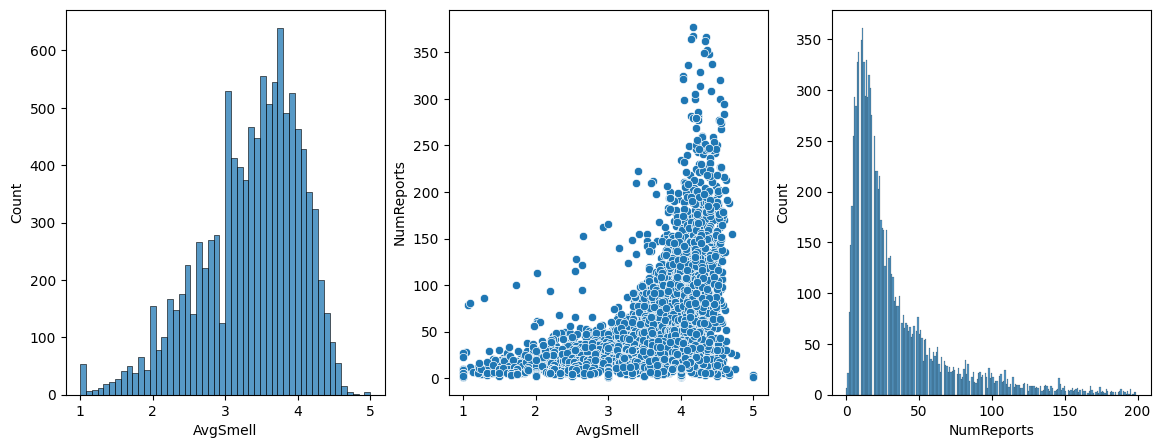

In [7]:
fig, ax = plt.subplots(1,3, figsize=(14, 5))

sns.histplot(data=ts_data['AvgSmell'], bins = 50, ax=ax[0])
sns.scatterplot(data=ts_data, x='AvgSmell', y='NumReports', ax=ax[1])
sns.histplot(data=ts_data[ts_data['NumReports'] < 200]['NumReports'], bins = 220, ax=ax[2])


[Text(0.5, 0, 'New metric: Avg. Smell * Num. of Reports'), Text(0, 0.5, '')]

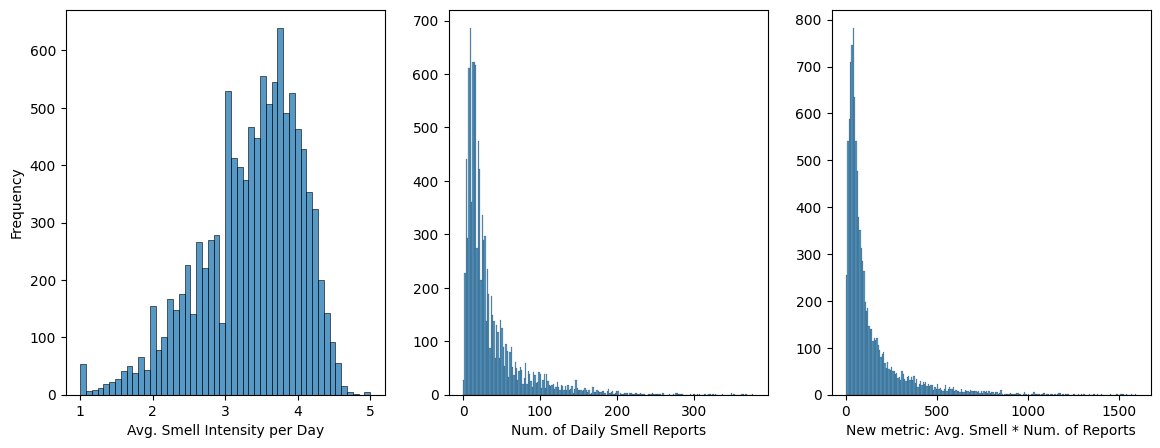

In [8]:
from scipy.stats import norm

def log(x):
    return 0 if x == 0 else np.log(x)

#To estimate the mu and sigma of the log normal distribution    
missing_data = len(ts_data[ts_data['NumReports'] < 1])
n = ts_data.shape[0] - missing_data
mu = ts_data['NumReports'].apply(lambda count: log(count)).sum() / n
sigma = np.sqrt(ts_data['NumReports'].apply(lambda count: (log(count) - mu)**2).sum() / (n - 1))


#To calculate the quantile
def cdf(x):
    #return lognorm(s=sigma, scale=math.exp(mu)).cdf(x)    
    return norm.ppf(lognorm(s=sigma, scale=math.exp(mu)).cdf(x))


def custom_metric(avg_mean, num_reports, max_intensity_score = np.log(5)):
    mean_score =  avg_mean/5#np.log(avg_mean)/np.log(5)
    reports_score = cdf(num_reports)

    return (avg_mean * num_reports) #(mean_score + reports_score)/2


ts_data["smell_metric"] = ts_data.apply(lambda df: custom_metric(df.AvgSmell, df.NumReports), axis=1)

fig, ax = plt.subplots(1,3, figsize=(14, 5))

label = sns.histplot(data=ts_data['AvgSmell'], bins = 50, ax=ax[0])
label.set(xlabel='Avg. Smell Intensity per Day', ylabel='Frequency')
label = sns.histplot(data=ts_data[ts_data['NumReports'] < 500]['NumReports'], bins = 220, ax=ax[1])
label.set(xlabel='Num. of Daily Smell Reports', ylabel='')
label = sns.histplot(data=ts_data['smell_metric'], bins = 220, ax=ax[2])
label.set(xlabel='New metric: Avg. Smell * Num. of Reports', ylabel='')



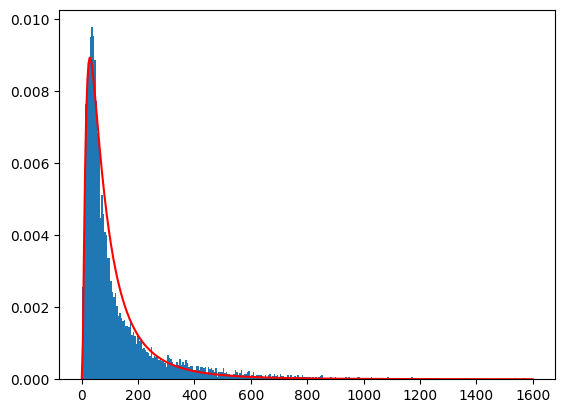

In [9]:
shape,loc,scale = lognorm.fit(ts_data['smell_metric'].dropna())
x = np.linspace(0, 1600, 400)
pdf = lognorm(s=sigma, scale=scale).pdf(x)
plt.plot(x, pdf, 'r')
plt.hist(ts_data['smell_metric'].dropna(), bins = 300, density=True)
plt.show()

In [10]:
for i in range (0, 15):
    i = i * 10
    new_data = ts_data.loc[(ts_data['NumReports'] >= i) & (ts_data['NumReports'] < i + 10)]
    print(f"Avg. report intensity in days with [{i} - {i + 10}) reports, Avg. intensity: {round(new_data['AvgSmell'].mean(), 4)}, New metric: {round(new_data['smell_metric'].mean(), 6)})")

Avg. report intensity in days with [0 - 10) reports, Avg. intensity: 2.8945, New metric: 18.359731)
Avg. report intensity in days with [10 - 20) reports, Avg. intensity: 3.1256, New metric: 44.544293)
Avg. report intensity in days with [20 - 30) reports, Avg. intensity: 3.2936, New metric: 79.21609)
Avg. report intensity in days with [30 - 40) reports, Avg. intensity: 3.4867, New metric: 118.608091)
Avg. report intensity in days with [40 - 50) reports, Avg. intensity: 3.6512, New metric: 162.491308)
Avg. report intensity in days with [50 - 60) reports, Avg. intensity: 3.7632, New metric: 203.268078)
Avg. report intensity in days with [60 - 70) reports, Avg. intensity: 3.866, New metric: 247.886395)
Avg. report intensity in days with [70 - 80) reports, Avg. intensity: 3.9514, New metric: 293.398954)
Avg. report intensity in days with [80 - 90) reports, Avg. intensity: 3.9768, New metric: 333.863814)
Avg. report intensity in days with [90 - 100) reports, Avg. intensity: 3.9475, New metri

In order to get more insights of the reports' location, we calculate whether the locations were focused in one area or were more dispersed.

<AxesSubplot: xlabel='dispersion', ylabel='Count'>

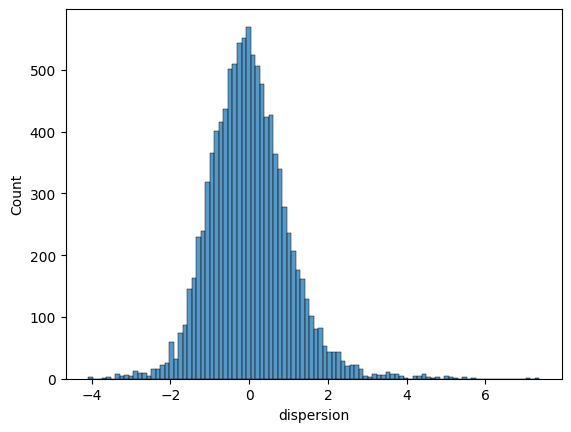

In [11]:
from scipy.stats import norm

class ReportsDispersion():
    """ The dispersion of the location of the reports follow a normal distribution """
    def __init__(self, longitudinal_data, windows) -> None:
        """ Send the raw reports data and the windows you've specified """
        self.data = longitudinal_data[['EpochTime', 'skewed_latitude', 'skewed_longitude']]
        self.windows = windows.copy()
        self.windows['dispersion'] = self.windows.apply(lambda row: self.__get_dispersion(row['EpochStart'], row['EpochEnds']), axis=1)
        self.__mu = np.mean(self.windows['dispersion'])
        self.__sigma = np.std(self.windows['dispersion'])

    def __get_dispersion(self, epochstart, epochend):  
        """ Returns the dispersion in a time range """
        filtered = self.data.loc[(self.data["EpochTime"] >= epochstart) & (self.data["EpochTime"] < epochend)]
        dispersion = np.mean((filtered['skewed_latitude'].std(), filtered['skewed_longitude'].std())) 
        return dispersion

    def get_dispersion_stand(self, epochstart, epochend):
        """ Returns cdf value per each dispersion value according to a normal distribution """
        dispersion = self.windows.loc[(self.windows["EpochStart"] == epochstart) & (self.windows["EpochEnds"] == epochend)]['dispersion'].item()
        return self.__get_zscore(value=dispersion)

    def __get_zscore(self, value):
        """ Returns cdf value per each dispersion value according to a normal distribution """
        #return self.norm_distr.pdf(x=value)
        return (value - self.__mu)/self.__sigma


dispersion_feature = ReportsDispersion(data, ts_data[['EpochStart', 'EpochEnds']])
ts_data['dispersion'] = ts_data.apply(lambda row: dispersion_feature.get_dispersion_stand(row["EpochStart"], row["EpochEnds"]), axis=1)

sns.histplot(ts_data['dispersion'], bins=100)


#### Which features can we extract from the text-inputs?

The most common tokens (both 1-gram and 2-grams) are the following ones. If reports include these tokens we can identify different types of strong odors. The final goal is to create an embedding that could describe two types of odors (sulfur-like odor and smoke-like odor for instance)

<AxesSubplot: xlabel='frequency', ylabel='bigram'>

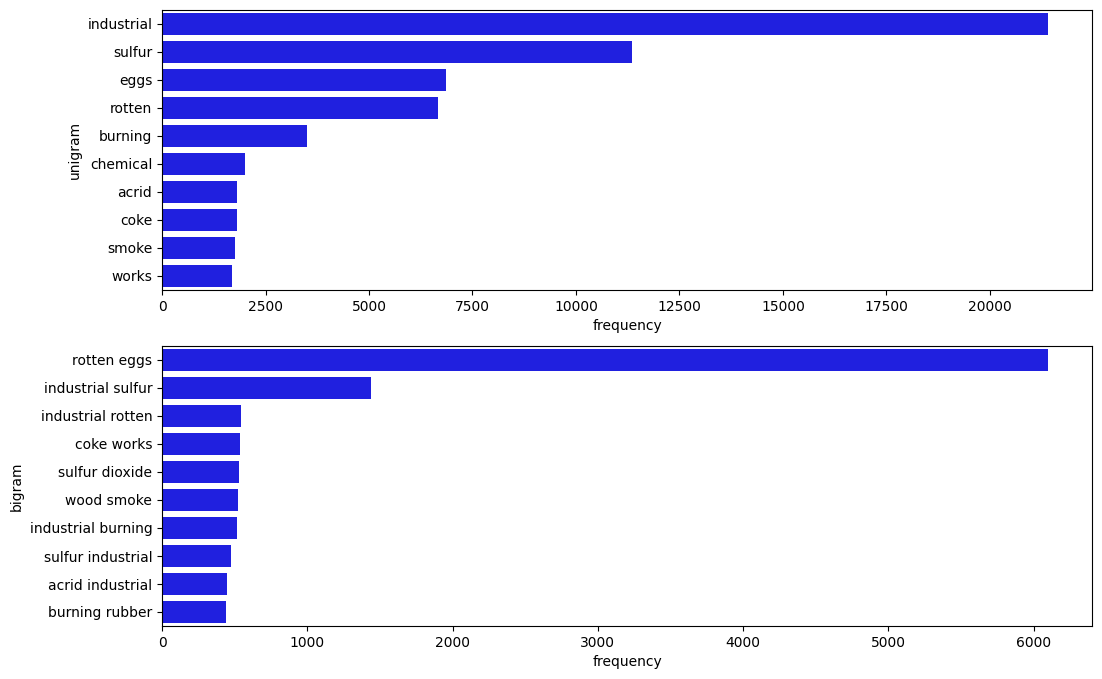

In [13]:
from collections import defaultdict
from itertools import islice
import re

def take_word(n, iterable):
    """Return the first n items of the iterable as a list."""
    return pd.DataFrame(list(islice(iterable, n)), columns=['unigram', 'frequency'])

def take_bigram(n, iterable):
    """Return the first n items of the iterable as a list."""
    return pd.DataFrame(list(islice(iterable, n)), columns=['bigram', 'frequency'])

def normalize(word):
    if word == 'sulphur':
        return 'sulfur'
    elif word == 'egg':
        return 'eggs'
    else:
        return word

stopwords = ['and', 'like', 'clairton', '', 'of', 'from', 'smells', 'smell', 'the', 'a', 'us', 'in', 'stench', 'air']

inputs = data['smell_description'].dropna().values
tokens = defaultdict(int)
bigram_tokens = defaultdict(int)

for ind_input in inputs:
    document = ind_input.split()
    previous = ""
    for token in document:
        current = normalize(re.sub(r'[^\w]', "", token.lower()))
        if current not in stopwords:
            tokens[current] += 1
        if previous != "":
            if current not in stopwords and previous not in stopwords:
                bigram = previous + " " + current
                bigram_tokens[bigram] += 1
                previous = current
        else:
            previous = re.sub(r'[^\w]', "", token.lower())

tokens = take_word(10, {k: v for k, v in sorted(tokens.items(), key=lambda item: item[1], reverse=True)}.items())
bigrams = take_bigram(10, {k: v for k, v in sorted(bigram_tokens.items(), key=lambda item: item[1], reverse=True)}.items())

fig, ax =plt.subplots(2,1, figsize=(12, 8))
sns.color_palette("pastel")
sns.barplot(x="frequency", y="unigram", data=tokens, color='b', orient='h', ax=ax[0])
sns.barplot(x="frequency", y="bigram", data=bigrams, color='b',orient='h', ax=ax[1])

#### Sensor Stations data

Embedding the information of the sensor stations into two values requires more time so it hasn't been done yet.

<AxesSubplot: xlabel='avg_so2', ylabel='Count'>

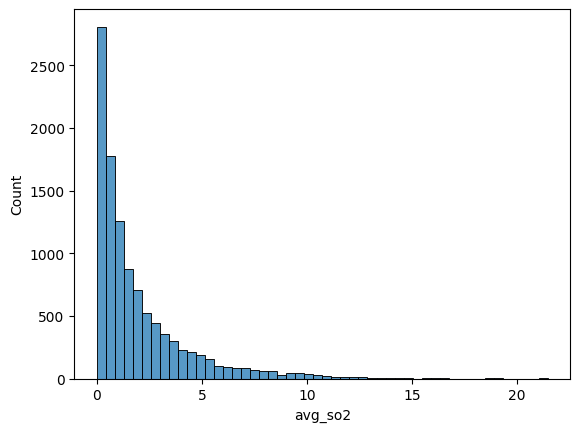

In [14]:
class SO2Loader:
    def __init__(self):
        so2_liberty = pd.read_csv('../Data/dataset/v2.1/esdr_raw/Feed_28_Liberty_ACHD.csv')[['EpochTime', '3.feed_28.SO2_PPM']]
        so2_avalon  = pd.read_csv('../Data/dataset/v2.1/esdr_raw/Feed_1_Avalon_ACHD.csv')[['EpochTime', '3.feed_1.SO2_PPM']]
        so2_northbraddock = pd.read_csv('../Data/dataset/v2.1/esdr_raw/Feed_3_North_Braddock_ACHD.csv')[['EpochTime', '3.feed_3.SO2_PPM']]

        so2_liberty = so2_liberty.rename(columns={'3.feed_28.SO2_PPM': 'SO2_PPM'})
        so2_avalon  = so2_avalon.rename(columns={'3.feed_1.SO2_PPM': 'SO2_PPM'})
        so2_northbraddock = so2_northbraddock.rename(columns={'3.feed_3.SO2_PPM': 'SO2_PPM'})

        self.data = pd.concat([so2_liberty, so2_avalon, so2_northbraddock])
        #We transform S02 to PPK to make all values not decimal
        self.data['SO2_PPM'] = self.data['SO2_PPM'] * 1000
        #We filter negative values (errors)
        self.data = self.data[self.data['SO2_PPM'] >= 0]

class SensorData:
    def __init__(self, wind_data) -> None:
        self.data = wind_data

    def get_avg_sensor_data(self, date_init, date_end):
        avg_sensor = self.data.loc[(self.data['EpochTime'] >= date_init) & (self.data['EpochTime'] < date_end)].groupby('EpochTime').agg({"SO2_PPM": 'mean'})['SO2_PPM']
        return avg_sensor.mean()  


sensor_data = SensorData(SO2Loader().data)

ts_data['avg_so2'] = ts_data.apply(lambda row: sensor_data.get_avg_sensor_data(row.EpochStart, row.EpochEnds), axis=1)
sns.histplot(ts_data['avg_so2'], bins=50)


1.9923253815550133 2.437508021175649


<AxesSubplot: xlabel='avg_so2', ylabel='Count'>

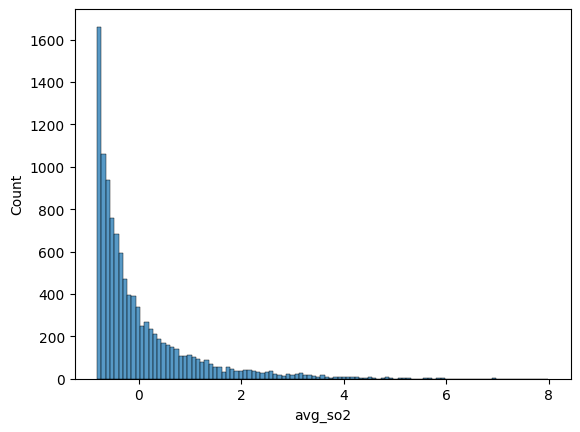

In [15]:
mean = ts_data['avg_so2'].mean()
sd = ts_data['avg_so2'].std()

print(mean, sd)
lambda_ = 1/2

sns.histplot((ts_data['avg_so2'] - mean)/sd)

<AxesSubplot: xlabel='avg_h2s', ylabel='Count'>

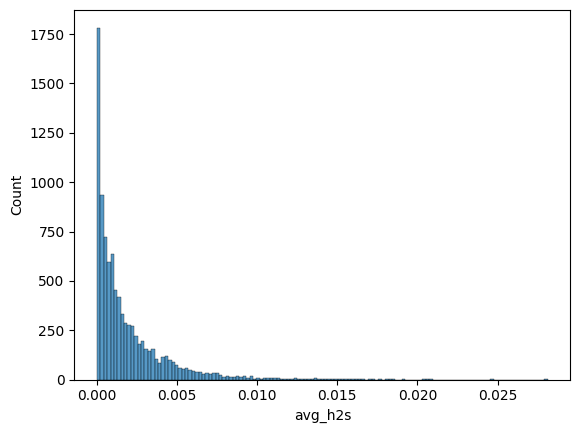

In [16]:
class H2SLoader:
    def __init__(self):
        h2s_liberty = pd.read_csv('../Data/dataset/v2.1/esdr_raw/Feed_28_Liberty_ACHD.csv')[['EpochTime', '3.feed_28.H2S_PPM']]
        h2s_avalon  = pd.read_csv('../Data/dataset/v2.1/esdr_raw/Feed_1_Avalon_ACHD.csv')[['EpochTime', '3.feed_1.H2S_PPM']]
        
        h2s_liberty = h2s_liberty.rename(columns={'3.feed_28.H2S_PPM': 'H2S_PPM'})
        h2s_avalon  = h2s_avalon.rename(columns={'3.feed_1.H2S_PPM': 'H2S_PPM'})
        
        self.data = pd.concat([h2s_liberty, h2s_avalon])
        #We transform S02 to PPK to make all values not decimal
        self.data['SO2_PPM'] = self.data['H2S_PPM'] * 1000 * 1000
        #We filter negative values (errors)
        self.data = self.data[self.data['H2S_PPM'] >= 0]
        self.name = 'H2S_PPM'

class SensorData:
    def __init__(self, wind_data, name_particle) -> None:
        self.data = wind_data
        self.name = name_particle

    def get_avg_sensor_data(self, date_init, date_end):
        avg_sensor = self.data.loc[(self.data['EpochTime'] >= date_init) & (self.data['EpochTime'] < date_end)].groupby('EpochTime').agg({self.name: 'mean'})[self.name]
        return avg_sensor.mean()  

h2s = H2SLoader()
h2s_data = h2s.data
h2s_name = h2s.name

sensor_data = SensorData(h2s_data, h2s_name)

ts_data['avg_h2s'] = ts_data.apply(lambda row: sensor_data.get_avg_sensor_data(row.EpochStart, row.EpochEnds), axis=1)
sns.histplot(ts_data[ts_data['avg_h2s'] > 0]['avg_h2s'])


<AxesSubplot: xlabel='avg_h2s', ylabel='Count'>

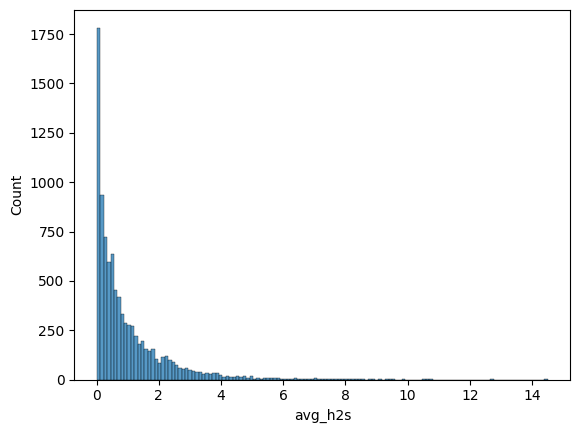

In [17]:
sd = ts_data['avg_h2s'].std()
zero_infalted = ts_data[ts_data['avg_h2s'] > 0]['avg_h2s']
mean = zero_infalted.mean()

sns.histplot(zero_infalted/mean)

#### Wind

Wind is one of the most important features to take into consideration as it can be useful for identifying where the odor is coming from.
In this analysis we've only taken the wind measure from one sensor station to make it easier but all the wind measurements should be taken instead.

In [18]:
from scipy.stats import rayleigh

class WindDataLoader:
    def __init__(self):
        wind_avalon = pd.read_csv('../Data/dataset/v2.1/esdr_raw/Feed_1_Avalon_ACHD.csv')
        wind_lawrence = pd.read_csv('../Data/dataset/v2.1/esdr_raw/Feed_26_Lawrenceville_ACHD.csv')
        wind_liberty = pd.read_csv('../Data/dataset/v2.1/esdr_raw/Feed_28_Liberty_ACHD.csv')
        wind_flagplaza = pd.read_csv('../Data/dataset/v2.1/esdr_raw/Feed_43_and_Feed_11067_Parkway_East_ACHD.csv')
        wind_braddock = pd.read_csv('../Data/dataset/v2.1/esdr_raw/Feed_3_North_Braddock_ACHD.csv')

        wind_avalon['SONICWD_DEG_SIN'] = np.sin(np.deg2rad(wind_avalon['3.feed_1.SONICWD_DEG'].apply(lambda angle: self.mathAngle2MeteoAngle(angle))))
        wind_lawrence['SONICWD_DEG_SIN'] = np.sin(np.deg2rad(wind_lawrence['3.feed_26.SONICWD_DEG'].apply(lambda angle: self.mathAngle2MeteoAngle(angle))))
        wind_liberty['SONICWD_DEG_SIN'] = np.sin(np.deg2rad(wind_liberty['3.feed_28.SONICWD_DEG'].apply(lambda angle: self.mathAngle2MeteoAngle(angle))))
        wind_flagplaza['SONICWD_DEG_SIN'] = np.sin(np.deg2rad(wind_flagplaza['3.feed_11067.SONICWD_DEG..3.feed_43.SONICWD_DEG'].apply(lambda angle: self.mathAngle2MeteoAngle(angle))))
        wind_braddock['SONICWD_DEG_SIN'] = np.sin(np.deg2rad(wind_braddock['3.feed_3.SONICWD_DEG'].apply(lambda angle: self.mathAngle2MeteoAngle(angle))))

        wind_avalon['SONICWD_DEG_COS'] = np.cos(np.deg2rad(wind_avalon['3.feed_1.SONICWD_DEG'].apply(lambda angle: self.mathAngle2MeteoAngle(angle))))
        wind_lawrence['SONICWD_DEG_COS'] = np.cos(np.deg2rad(wind_lawrence['3.feed_26.SONICWD_DEG'].apply(lambda angle: self.mathAngle2MeteoAngle(angle))))
        wind_liberty['SONICWD_DEG_COS'] = np.cos(np.deg2rad(wind_liberty['3.feed_28.SONICWD_DEG'].apply(lambda angle: self.mathAngle2MeteoAngle(angle)))) 
        wind_flagplaza['SONICWD_DEG_COS'] = np.cos(np.deg2rad(wind_flagplaza['3.feed_11067.SONICWD_DEG..3.feed_43.SONICWD_DEG'].apply(lambda angle: self.mathAngle2MeteoAngle(angle))))
        wind_braddock['SONICWD_DEG_COS'] = np.cos(np.deg2rad(wind_braddock['3.feed_3.SONICWD_DEG'].apply(lambda angle: self.mathAngle2MeteoAngle(angle))))

        wind_avalon = wind_avalon.rename(columns={'3.feed_1.SONICWS_MPH': 'SONICWS_MPH'})[['EpochTime', 'SONICWS_MPH','SONICWD_DEG_SIN', 'SONICWD_DEG_COS']]
        wind_lawrence = wind_lawrence.rename(columns={'3.feed_26.SONICWS_MPH': 'SONICWS_MPH'})[['EpochTime', 'SONICWS_MPH','SONICWD_DEG_SIN', 'SONICWD_DEG_COS']]
        wind_liberty = wind_liberty.rename(columns={'3.feed_28.SONICWS_MPH': 'SONICWS_MPH'})[['EpochTime', 'SONICWS_MPH','SONICWD_DEG_SIN', 'SONICWD_DEG_COS']]
        wind_flagplaza = wind_flagplaza.rename(columns={'3.feed_11067.SONICWS_MPH..3.feed_43.SONICWS_MPH': 'SONICWS_MPH'})[['EpochTime', 'SONICWS_MPH','SONICWD_DEG_SIN', 'SONICWD_DEG_COS']]
        wind_braddock = wind_braddock.rename(columns={'3.feed_3.SONICWS_MPH': 'SONICWS_MPH'})[['EpochTime', 'SONICWS_MPH','SONICWD_DEG_SIN', 'SONICWD_DEG_COS']]

        self.wind_data = pd.concat([wind_avalon, wind_braddock, wind_flagplaza, wind_lawrence, wind_liberty])
    
    def mathAngle2MeteoAngle(self, angle):
        meteo_angle = 270 - angle
        return meteo_angle if meteo_angle >= 0 else meteo_angle + 365

class WindData:
    def __init__(self, wind_data, reports_data):
        self.data = wind_data
        untreated_reports_data = reports_data.groupby('EpochTime', as_index=False)[['smell_value']].agg(lambda x: x.astype(int).count())
        self.data['num_reports'] = self.data['EpochTime'].apply(lambda epoch: \
                                    untreated_reports_data.loc[(untreated_reports_data['EpochTime'] >= epoch) &\
                                                                (untreated_reports_data['EpochTime'] < epoch + 3600)]['smell_value'].sum())
        sigma = np.sqrt(np.mean(self.data['SONICWS_MPH'] **2) / 2)
        self.__windspeed_distr = rayleigh(scale=sigma)

    def wind_max_speed(self, date_init, date_end):
        """ We'll take the average wind speed during the windiest 5 hours to see if it's been a 'windy' day """
        wind_speeds = self.data.loc[(self.data['EpochTime'] >= date_init) & (self.data['EpochTime'] < date_end)].groupby('EpochTime').agg({"SONICWS_MPH": 'mean'})['SONICWS_MPH']
        return self.__get_zscore(self.__windspeed_distr.cdf(np.average(wind_speeds.to_numpy())))
    
    def __get_zscore(self, quantile):
        return norm.ppf(quantile)

    def __weighted_average_direction(self, wind_directions, sin):
        """ Get weighted average wind direction given a period of time """
        column = "SONICWD_DEG_SIN" if sin else "SONICWD_DEG_COS"
        weights = wind_directions['num_reports'].to_numpy()
        weights = np.array([1]*len(weights)) if np.sum(weights) == 0 else weights
        directions = wind_directions[column].to_numpy()
        return np.average(directions, weights=weights)

    def wind_day_direction_cos(self, date_init, date_end):
        """ We'll take the avg wind direction during the period of time there were more reports that day """
        wind_directions = self.data.loc[(self.data['EpochTime'] >= date_init) & (self.data['EpochTime'] < date_end)].groupby('EpochTime').\
            agg({"num_reports": 'mean', 'SONICWD_DEG_COS': 'mean'})
        return self.__weighted_average_direction(wind_directions, False)
    
    def wind_day_direction_sin(self, date_init, date_end):
        """ We'll take the avg wind direction during the period of time there were more reports that day """
        wind_directions = self.data.loc[(self.data['EpochTime'] >= date_init) & (self.data['EpochTime'] < date_end)].groupby('EpochTime').\
            agg({"num_reports": 'mean', 'SONICWD_DEG_SIN': 'mean'})
        return self.__weighted_average_direction(wind_directions, True)
    
    def wind_day_direction_std(self, date_init, date_end):
        """ Average standard deviation of sin and cos std"""
        wind_directions_sin = self.data.loc[(self.data['EpochTime'] >= date_init) & (self.data['EpochTime'] < date_end)].groupby('EpochTime').\
            agg({'SONICWD_DEG_SIN': 'mean'})
        wind_directions_cos = self.data.loc[(self.data['EpochTime'] >= date_init) & (self.data['EpochTime'] < date_end)].groupby('EpochTime').\
            agg({'SONICWD_DEG_COS': 'mean'})
        return np.mean((wind_directions_sin['SONICWD_DEG_SIN'].std(), wind_directions_cos['SONICWD_DEG_COS'].std()))
        

In [20]:
wind_data = WindDataLoader().wind_data
xxxx = WindData(wind_data=wind_data, reports_data=pd.read_csv("../Data/dataset/v2.1/smell_raw.csv"))

In [21]:
ts_data['wind_speed'] = ts_data.apply(lambda ts: xxxx.wind_max_speed(date_init=ts['EpochStart'], date_end=ts['EpochEnds']), axis=1)
ts_data['wind_cos'] = ts_data.apply(lambda ts: xxxx.wind_day_direction_cos(date_init=ts['EpochStart'], date_end=ts['EpochEnds']), axis=1)
ts_data['wind_sin'] = ts_data.apply(lambda ts: xxxx.wind_day_direction_sin(date_init=ts['EpochStart'], date_end=ts['EpochEnds']), axis=1)
ts_data['wind_std'] = ts_data.apply(lambda ts: xxxx.wind_day_direction_std(date_init=ts['EpochStart'], date_end=ts['EpochEnds']), axis=1)

ts_data

,EpochStart,EpochEnds,Date,Hour,AvgSmell,NumReports,smell_metric,dispersion,avg_so2,avg_h2s,wind_speed,wind_cos,wind_sin,wind_std
0,1477935134,1478021534,2016-10-31,13,2.933333,36,105.600000,-1.578301,1.111111,0.000333,-1.079438,-0.222816,0.280321,0.350382
1,1477953134,1478039534,2016-10-31,18,3.034483,35,106.206897,-1.645146,1.694444,0.000604,-0.854554,-0.156433,0.363363,0.449233
2,1477971134,1478057534,2016-10-31,23,2.939394,39,114.636364,-2.020338,3.861111,0.001896,-0.777377,-0.164777,0.351290,0.379888
3,1477989134,1478075534,2016-11-01,04,2.906250,38,110.437500,-2.001268,6.458333,0.003750,-0.714382,-0.171512,0.350520,0.311245
4,1478007134,1478093534,2016-11-01,09,3.587500,100,358.750000,-2.296753,8.194444,0.004812,-0.569402,-0.265060,0.562901,0.269112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10706,1670643134,1670729534,2022-12-09,22,4.133333,17,70.266667,0.215788,0.083333,0.000042,-0.778010,-0.745978,0.284016,0.303994
10707,1670661134,1670747534,2022-12-10,03,4.133333,17,70.266667,0.093599,0.000000,0.000000,-0.810314,-0.750742,0.339001,0.258599
10708,1670679134,1670765534,2022-12-10,08,4.076923,15,61.153846,0.108148,0.000000,0.000000,-0.764740,-0.751731,0.427353,0.154084
10709,1670697134,1670783534,2022-12-10,13,4.000000,11,44.000000,-0.236565,0.000000,0.000000,-0.784142,-0.768472,0.460793,0.102241


<AxesSubplot: xlabel='wind_speed', ylabel='Count'>

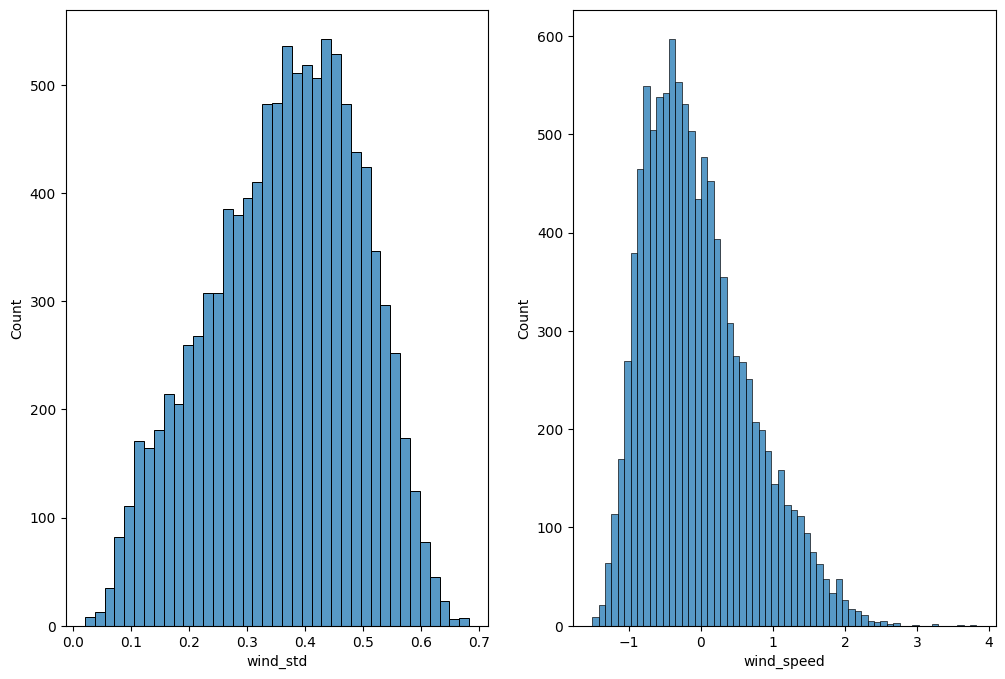

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
sns.histplot(ts_data['wind_std'], ax=ax[0])
sns.histplot(ts_data['wind_speed'], ax=ax[1])